<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/nnUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Data

In [1]:
import gdown
url = 'https://drive.google.com/uc?id=1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3'
gdown.download(url,'train_valid.zip',quiet=True)
!unzip -q train_valid.zip

Download Code

In [2]:
!git clone https://github.com/NVIDIA/DeepLearningExamples.git
%cd DeepLearningExamples/PyTorch/Segmentation/nnUNet

Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 33170, done.
remote: Counting objects: 100% (993/993), done.
remote: Compressing objects: 100% (685/685), done.
remote: Total 33170 (delta 348), reused 870 (delta 281), pack-reused 32177
Receiving objects: 100% (33170/33170), 106.96 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (23228/23228), done.
Updating files: 100% (5338/5338), done.
/content/DeepLearningExamples/PyTorch/Segmentation/nnUNet


Required installation:

In [4]:
!pip -q install monai pytorch-lightning git+https://github.com/NVIDIA/dllogger git+https://github.com/NVIDIA/mlperf-common.git -U rich
#check nvidia-smi for nvidia version
#if nvidia version is 12.++ then use below command
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda120

#if nvidia version is 11.++ then use below command
# !pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.7/239.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 10.5 MB/s eta 0:00:00


#Data pre-processing
Create 2 folders 1 file:<br>
Folder1 = images: stack 4 input MRIs into one (240, 240, 155, 4) for each case <br>
Fodler2 = labels: split the seg mask into this folder for each case<br>
file = dataset.jason: mapped each image and corresponding label, mapped label names

In [5]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)


def prepare_nifty(d):
    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))

    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "_seg.nii.gz"))


def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "_" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "flair" in f or "t1" in f or "t1ce" in f or "t2" in f:
                    continue
                if "_seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS19 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

prepare_dataset("/content/train_valid", True)
# prepare_dataset("/data/BraTS2021_val", False)
print("Finished!")

Preparing BraTS19 dataset from: /content/train_valid
Preparing time: 92.05
Finished!


Checking stacked images and labels:

In [6]:
import nibabel as nib
import numpy as np
img = nib.load('/content/train_valid/images/BraTS19_2013_0_1.nii.gz')
lab = nib.load('/content/train_valid/labels/BraTS19_2013_0_1_seg.nii.gz')
print('Stacked Images:', img.get_fdata().shape, 'Label:', lab.get_fdata().shape)

Stacked Images: (240, 240, 155, 4) Label: (240, 240, 155)


Cropping and normalizing the volumes:<br>
1. crop the background padding (with voxel value zero)<br>
2. compute mean and the standard deviation  within the non-zero region for each channel separately<br>
3. The background voxels are not normalized so that their value remained at zero

Editing config file to rename the file name to fit with custom dataset

In [3]:
def replace_text_in_file(search_path, replace_path, search_text=None, replace_text=None):
    with open(search_path, 'r') as file: content = file.read()
    modified_content = content.replace(search_text, replace_text)
    with open(replace_path, 'w') as file: file.write(modified_content)

file_path = 'data_preprocessing/configs.py'
replace_text_in_file(file_path, file_path, search_text='BraTS2021_train', replace_text='train_valid')

Cropping and Normalizing:
1. Transpose stacked volume in to pytorch format [B x C x D x H x W] <br>
1. Creating a folder with name 11_3d and store 4 normalized files for each case:<br>
(i) _x.npy (): To distinguish between background voxels and normalized voxels which have values close to zero, we add an input channel with one-hot encoding for foreground voxels and stacked with the input data. As a result, each example has 5 channels.<br>
(ii) _y.npy(): Cropped label which is same as _orig_lbl.npy()<br>
(iii) _orig_lbl.npy(): cropped original label<br>
(iv) _meta.npy(): cropping information with 4 coordinates:[[zmin, xmin, ymin], [zmax, xmax, ymax],[z, x, y],[zcrop, xcrop, ycrop]<br>
2. config.pkl: a dictionary with the information of patch size, channel and classes like<br>
{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4 'in_channels': 5}


In [8]:
# If there is any error with MKL then run the first command then restart the notebook then run the both commands
# !export MKL_SERVICE_FORCE_INTEL=1
!python3 preprocess.py --task 11 --ohe --exec_mode training --data /content --results /content/train_valid

2023-07-29 18:43:53.776857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 18:43:54.836296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Preprocessing /content/train_valid
2023-07-29 18:44:08.972913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-29 18:44:08.977944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Pre-processing time: 167.57


visualization after normalised and cropped

_x: (5, 133, 159, 133) _y: (1, 133, 159, 133) _orig_lbl: (1, 133, 159, 133) _meta: (4, 3)
_meta: [[  7  51  52]
 [140 210 185]
 [155 240 240]
 [133 159 133]]
{'patch_size': [128, 128, 128], 'spacings': [1.0, 1.0, 1.0], 'n_class': 4, 'in_channels': 5}


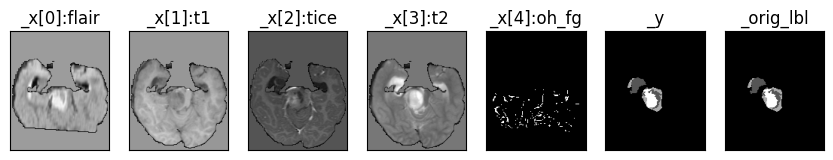

In [9]:
import matplotlib.pyplot as plt
_x = np.load('/content/train_valid/11_3d/BraTS19_2013_0_1_x.npy')
_y = np.load('/content/train_valid/11_3d/BraTS19_2013_0_1_y.npy')
_orig_lbl = np.load('/content/train_valid/11_3d/BraTS19_2013_0_1_orig_lbl.npy')
_meta = np.load('/content/train_valid/11_3d/BraTS19_2013_0_1_meta.npy')
print('_x:',_x.shape,'_y:', _y.shape,'_orig_lbl:', _orig_lbl.shape,'_meta:', _meta.shape)
print('_meta:',_meta)

import pickle
with open('/content/train_valid/11_3d/config.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

num_img = 7
slice_n = 40
fig, ax = plt.subplots(1, num_img, figsize=(1.5*num_img,7), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(_x[0,slice_n,], cmap='gray')
ax[0].set_title('_x[0]:flair')
ax[1].imshow(_x[1,slice_n,], cmap='gray')
ax[1].set_title('_x[1]:t1')
ax[2].imshow(_x[2,slice_n,], cmap='gray')
ax[2].set_title('_x[2]:tice')
ax[3].imshow(_x[3,slice_n,], cmap='gray')
ax[3].set_title('_x[3]:t2')
ax[4].imshow(_x[4,slice_n,], cmap='gray')
ax[4].set_title('_x[4]:oh_fg')
ax[5].imshow(_y[0,slice_n,], cmap='gray')
ax[5].set_title('_y', );
ax[6].imshow(_orig_lbl[0,slice_n,], cmap='gray')
ax[6].set_title('_orig_lbl');

# Data Augmentations <a name="augmentations"></a>

Data augmentation is a technique that alleviates the overfitting problem by artificially extending a dataset during the training phase. To make our method more robust, the following data augmentations are used during training phase:

1. **Biased crop**: From the input volume, a patch of dimensions (5, 128, 128, 128) was randomly cropped. Additionally, with probability of 0.4 the patch selected via random biased crop is guaranteed that some foreground voxels (with positive class in the ground truth) are present in the cropped region.
2. **Zoom**: With probability of 0.15, a zoom factor is sampled uniformly from (1.0, 1.4) and then input volume is zoomed by a sampled factor with cubic interpolation, while label with nearest neighbor interpolation.
3. **Flips**: With probability of 0.5, for each x, y, z axis independently, volume was flipped along that axis.
4. **Gaussian Noise**: With probability of 0.15, random Gaussian noise with mean zero and standard deviation sampled uniformly from (0, 0.33) is sampled for each voxel and added to the input volume.
5. **Gaussian Blur**: With probability of 0.15, Gaussian blurring with standard deviation of the Gaussian Kernel sampled uniformly from (0.5, 1.5) is applied to the input volume.
6. **Brightness**: With probability of 0.15, a random value is sampled uniformly from (0.7, 1.3) and then input volume voxels are multiplied by it.
7. **Contrast**: With probability of 0.15, a random value is sampled uniformly from (0.65, 1.5) and then input volume voxels are multiplied by it and clipped to its original min and max values.

The data loading pipeline is implemented with [NVIDIA Data Loading Library (DALI)](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html), which addresses the problem of the CPU bottleneck by offloading data augmentations to the GPU. We encourage you to check out the implementation details of our [DALI pipeline](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Segmentation/nnUNet/data_loading/dali_loader.py).

# Loss function <a name="loss"></a>

The BraTS leaderboard is computed based on three partially overlapping regions: whole tumor (1, 2, 4), tumor core (1, 4) and enhancing tumor (4), instead of classes present in the labels. Thus, it is beneficial to construct the loss function based on classes used for ranking calculation. Therefore, we optimize each region separately with a sum of binary Cross-Entropy with the Dice loss.

In [10]:
import torch.nn as nn
from monai.losses import DiceLoss

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

# Model <a name="model"></a>

We have made some modifications to the U-Net architecture for the BraTS challenge with respect to the original nnU-Net template. In particular, the U-Net template in the nnU-Net has the encoder depth of 6, and the convolution channels at each encoder level are: 32, 64, 128, 256, 320, 320. Based on the experiments we run, increasing the depth of the encoder to 7, modifying the number of channels to: 64, 96, 128, 192, 256, 384, 512, and using deep supervision improves the final score.

For deep supervision, we used two additional output heads at the decoder levels with feature map sizes (64, 64, 64) and (32, 32, 32). To match the shape of the additional predictions with the label shape of (128, 128, 128) we downsampled the label using the nearest neighbor interpolation to the (64, 64, 64) and (32, 32, 32) shapes, so that loss can be computed for additional outputs.

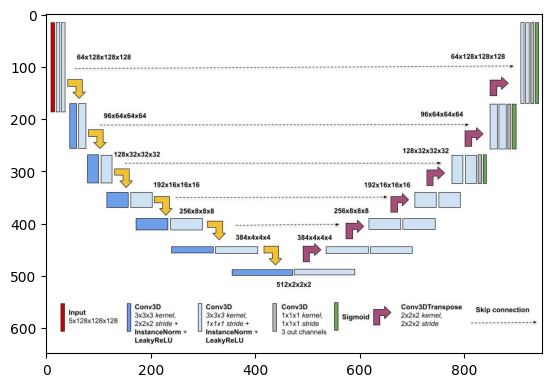

In [11]:
from IPython.display import Image
from PIL import Image
import matplotlib.pyplot as plt
# img = Image(filename="images/unet-brats.jpg")
img = Image.open("images/unet-brats.jpg")
plt.imshow(np.array(img))

Figure 1: *The final U-Net architecture used for BraTS21 challenge.*

# Training <a name="training"></a>

Now, let's start training the model. For that, we will call the training script from our nnUNet repo with some additional command line arguments for BraTS challenge:

- `--brats` - use loss function with partially overlapping regions (WT, TC, ET) and BraTS specific inference;
- `--deep_supervision` - use deep supervision loss with two additional output heads;
- `--more_chn` - create encoder with more channels than regular U-Net;
- `--min_fmap 2` - create deeper encoder, with feature map size in the bottleneck 2x2x2;

and the regular command line arguments:

- `--scheduler` - use cosine decay learning rate scheduler with warm up 250 steps of warm up;
- `--learning_rate 0.0003` - initial learning rate after warm up will be set to 0.0003;
- `--epochs 30` - training will be done for 30 epochs;
- `--fold 0` - training will be done for fold 0 (by default, 5-fold cross validation is used);
- `--amp` - training with automatic mixed precision, for faster training and memory reduction;
- `--gpus 1` - one GPU will be used during training;
- `--task 11` - task number for BraTS21 training dataset. See file `data_preprocessing/configs.py` for more details;
- `--save_ckpt` - save checkpoint with highest dice score acheived during training.

We will run training on 1xA100 GPU. To train the model with [AMP](https://developer.nvidia.com/automatic-mixed-precision), you will need a GPU with at least 15G memory.

Here, we will train the model on just 1-fold (fold with index 0) and 30 epochs. For the challenge submission, we have trained 5 models on each fold for 150 epochs, and averaged their predictions.

In [12]:
!mkdir ckpt_ours

In [7]:
def replace_text_in_file(search_path, replace_path, search_text=None, replace_text=None):
    with open(search_path, 'r') as file: content = file.read()
    modified_content = content.replace(search_text, replace_text)
    with open(replace_path, 'w') as file: file.write(modified_content)

file_path = 'nnunet/nn_unet.py'
replace_text_in_file(file_path, file_path, search_text='from apex.optimizers import FusedAdam, FusedSGD', replace_text='from torch.optim import Adam, SGD')
replace_text_in_file(file_path, file_path, search_text='FusedAdam', replace_text='Adam')
replace_text_in_file(file_path, file_path, search_text='FusedSGD', replace_text='SGD')
replace_text_in_file(file_path, file_path, search_text='validation_epoch_end', replace_text='on_validation_epoch_end')

In [ ]:
# !export MKL_SERVICE_FORCE_INTEL=1
!python main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --scheduler --learning_rate 0.0003 --epochs 30 --fold 0 --amp --gpus 1 --task 11 --save_ckpt --data /content/train_valid/11_3d --results /content/train_valid --ckpt_store_dir ckpt_ours

2023-07-29 19:26:23.167729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 19:26:24.110365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
52 training, 14 validation, 66 test examples
Provided checkpoint None is not a file. Starting training from scratch.
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 1